# Recommendation Systems

A recommendation system is an algorithm designed to suggest items to users. By the growth of data, it could be done based on the past favorite items, similarities to other users, or other behaviors. One application of recommendation systems is in e-commerce ,where the items here are products.

In this notebook, we use this algorithm for [MovieLens](https://movielens.org) dataset. We have a list of ratings (integer from $1$ to $5$) from some users to some movies. Our goal is to recommend movies to users such that they will find them helpful.

In [2]:
name = "Ghazal Zolfi Moselo"
student_id = "401104146"

## Table of Contents

- 1- Content Filtering and Collaborative Filtering
- 2- SVD for Collaborative Filtering
  - 2.1- Load data (5 p)
  - 2.2- Preprocess data (10 p)
  - 2.3- SVD model (50 p)
  - 2.4- Train (25 p)
  - 2.5- Recommend (20 p)

## 1- Content Filtering and Collaborative Filtering

There are many approaches for recommender systems.

**Content Filtering** is based on the features of items and the user’s past interactions. A user who watches romantic movies may like other romantic movies.

**Collaborative Filtering** is based on the behavior of other users. If two users watched many movies similarly, a movie liked by one user, probably the other user also like it.

## 2- SVD for Collaborative Filtering

In this notebook, we use collaborative filtering.

First, let's import needed libraries.

- [numpy](https://numpy.org): The fundamental package for scientific computing with Python.
- [pandas](https://pandas.pydata.org): Easy to use data analysis and manipulation tool.
- [matplotlib](https://matplotlib.org): For creating visualizations in Python.
- [sklearn](https://scikit-learn.org/stable/): We just use its split method.
- [tqdm](https://tqdm.github.io): Make loops show a smart progress meter.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import trange

### 2.1- Load data

Now, we load the ratings in a pandas DataFrame. There are $3$ columns that we will deal with: `userId`, `movieId`, and `rating`. In each row, a user rates a movie. Remove `timestamp` column. Find the total number of rows available. Show the first $5$ rows.

In [7]:
path = 'ml-latest-small/ratings.csv'
rating_data = pd.read_csv(path)
# TODO: remove timestamp column. print number of rows. show head. (≈3 lines)
rating_data.drop(columns=['timestamp'], inplace=True)
print(f'There are {len(rating_data)} ratings.')
rating_data.head(5)

There are 100836 ratings.


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### 2.2- Preprocess data

It is necessary that user ids be in $\{0, 1, ..., N-1\}$, and item ids in $\{0, 1, ..., M-1\}$, while there are $N$ unique users and $M$ unique ids. Find $N, M$ and preprocess ids. Using [unique](https://pandas.pydata.org/docs/reference/api/pandas.unique.html) and [map](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html) methods might be helpful.

In [8]:
# TODO: find N, M. preprocess ids. (≈8 lines)
unique_users = rating_data['userId'].unique()
N = len(unique_users)
unique_items = rating_data['movieId'].unique()
M = len(unique_items)
user_map = {user_id: idx for idx, user_id in enumerate(rating_data['userId'].unique())}
movie_map = {movie_id: idx for idx, movie_id in enumerate(rating_data['movieId'].unique())}
rating_data['userId'] = rating_data['userId'].map(user_map)
rating_data['movieId'] = rating_data['movieId'].map(movie_map)
print(f'There are {N} unique users and {M} unique items.')

There are 610 unique users and 9724 unique items.


We keep $20\%$ of ratings for validation to see our algorithm's performance on unseen data. Find the number of training and validation examples. It is recommended to [reset index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html) after splitting.

In [9]:
random_state = 42
# TODO: split with 80/20 ratio. print train/val size. (≈4 lines)
train_rating_data, val_rating_data = train_test_split(rating_data, test_size=0.2, random_state=random_state)
train_rating_data = train_rating_data.reset_index(drop=True)
val_rating_data = val_rating_data.reset_index(drop=True)
print(f'Train size= {len(train_rating_data)} , Validation size= {len(val_rating_data)}')

Train size= 80668 , Validation size= 20168


### 2.3- SVD model

In terms of matrices, we have the rating matrix $R \in \mathbb{R}^{N\times M}$. The $i$-th row of this matrix is the $i$-th user ratings for every movie. The challenge is that, we don't have some of the entries of $R$. We want to find some valuable features based on the available ratings to find the missing entries.

Think of the SVD for $R=U\Sigma V^T$ as user-feature matrix $U$, feature importance $\Sigma$, and item-feature matrix $V^T$. By selecting the top $k$ features, we reduce the dimensionality and capture latent factors representing user and item features. But we will solve this problem in a different manner.

We represent the predicted rating of the user $u$ to the item $i$ as $\hat{r}_{ui}$, the dot product of $p_u, q_i \in \mathbb{R}^{k}$. According to the [Low-rank approximation](https://en.wikipedia.org/wiki/Low-rank_approximation), the best performance we can achieve by this setting is equal to SVD. We add user $b_u$ and item $c_i$ bias for more flexibility.
$$
\hat{r}_{ui} = p_u^Tq_i + b_u + c_i
$$
The objective is to minimize the below loss function:
$$
\mathcal{L} = \sum_{u, i} \big[ (r_{ui} - \hat{r}_{ui})^2 + \lambda (b_u^2 + c_i^2 + ||p_u||^2 + ||q_i||^2) \big]
$$
where $\lambda$ is the regularization parameter and $||.||$ is the $l$-2 norm.

Store the above parameters in a class and implement `forward` and `backward` methods. You should use `np.random.randn` for parameter initialization.

In [10]:
class CollaborativeFiltering:
    def __init__(self, N, M, k, lr, _lambda):
        # TODO: initialize paramters. (≈6 lines)
        self.N = N
        self.M = M
        self.k = k
        self.lr = lr
        self._lambda = _lambda

        # Initialize latent factors and biases
        self.P = np.random.randn(N, k)  # User latent factors
        self.Q = np.random.randn(M, k)  # Item latent factors
        self.b_u = np.zeros(N)  # User biases
        self.c_i = np.zeros(M)  # Item biases

    def forward(self, u, i):
        # TODO: predicted rating for user u and item i. (≈1 line)
        return np.dot(self.P[u].T, self.Q[i]) + self.b_u[u] + self.c_i[i]

    def backward(self, u, i, r):
        # TODO: update paramters w.r.t the regularized loss function. (≈5 lines)
        r_hat = self.forward(u, i)
        error = r - r_hat
        d_p_u = -2 * error * self.Q[i] + 2 * self._lambda * self.P[u]
        d_q_i = -2 * error * self.P[u] + 2 * self._lambda * self.Q[i]
        d_b_u = -2 * error + 2 * self._lambda * self.b_u[u]
        d_c_i = -2 * error + 2 * self._lambda * self.c_i[i]
        self.P[u] -= self.lr * d_p_u
        self.Q[i] -= self.lr * d_q_i
        self.b_u[u] -= self.lr * d_b_u
        self.c_i[i] -= self.lr * d_c_i


k = 20
lr = 0.005
_lambda = 0.02
model = CollaborativeFiltering(N, M, k, lr, _lambda)

### 2.4- Train

Use Stochastic Gradient Descent to update the parameters of the model.

Evaluate your model with RMSE on validation set:
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{j=1}^n (r - \hat{r})^2}
$$
where $n$ is the number of examples in validation set.

In [11]:
def train(model: CollaborativeFiltering, df_train: pd.DataFrame):
    # TODO: iterate through the train set & update model parameters. (≈2 lines)
    for _, row in df_train.iterrows():
        u = int(row['userId'])
        i = int(row['movieId'])
        r = row['rating']
        model.backward(u, i, r)

def evaluate(model: CollaborativeFiltering, df_val: pd.DataFrame):
    # TODO: calculate RMSE for validation set. (≈10 lines)
    errors = []
    for _, row in df_val.iterrows():
        u = int(row['userId'])
        i = int(row['movieId'])
        r = row['rating']
        r_hat = model.forward(u, i)
        errors.append((r - r_hat) ** 2)
    rmse = np.sqrt(np.mean(errors))
    return rmse

def plot(y):
    plt.plot(range(1, len(y)+1), y)
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Collaborative Filtering with SVD')
    plt.show()

Each epoch should be done in about one second. The final RSME should be about $1.3$.

Training: 100%|██████████| 30/30 [05:12<00:00, 10.43s/it]


Final RMSE: 1.1676


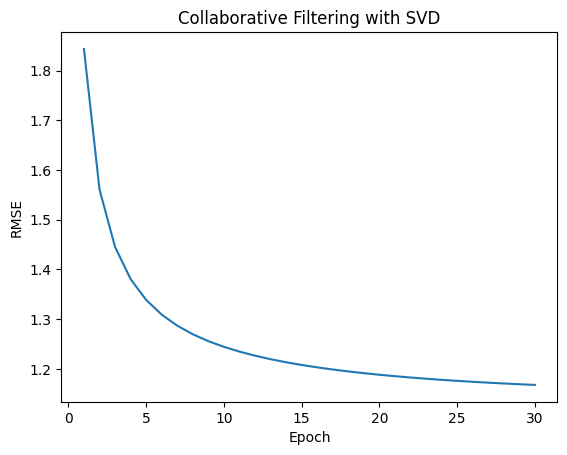

In [12]:
RMSEs = []
num_epochs = 30

for epoch in trange(num_epochs, desc='Training'):
  # TODO: train & evaluate one epoch. (≈3 lines)
    train(model, train_rating_data)
    rmse = evaluate(model, val_rating_data)
    RMSEs.append(rmse)

print(f'Final RMSE: {RMSEs[-1]:.4f}')

plot(RMSEs)

### 2.5- Recommend

The below cell will compare the unseen ratings with the predictions.

In [14]:
def get_candidate_items(user_id):
    # TODO: return movie_ids and ratings for user_id in validation set. (≈2 lines)
    user_data = val_rating_data[val_rating_data['userId'] == user_id]
    return user_data[['movieId', 'rating']]

def recommend_for_user(model, user_id):
    # TODO: return a dataframe with true and predicted ratings for user_id items in validation set. (≈10 lines)
    candidate_items = get_candidate_items(user_id)
    recommendations = []

    for _, row in candidate_items.iterrows():
        movie_id = int(row['movieId'])
        true_rating = row['rating']
        predicted_rating = model.forward(user_id, movie_id)
        recommendations.append({
            'Item Id': movie_id,
            'Real Rating': true_rating,
            'Pred Rating': predicted_rating
        })

    return pd.DataFrame(recommendations)

result = recommend_for_user(model, 200)
result

,Item Id,Real Rating,Pred Rating
0,539,3.0,3.765904
1,355,4.0,4.378495
2,392,4.0,5.680423
3,33,3.0,4.262128
4,130,4.0,3.177418
5,1583,5.0,5.021183
6,730,4.0,3.543725
7,173,3.0,3.571494
8,100,4.0,3.254666
9,271,4.0,3.795648


Good predictions! There are better techniques for collaborative filtering using neural networks. For more information see [this](https://www.nvidia.com/en-us/glossary/recommendation-system/) blog. As this blog said, recommender systems have very huge impact on the amount of sales for companies. I hope you find this notebook helpful. Thanks!